In [1]:
import jax
import infomec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

<Axes: >

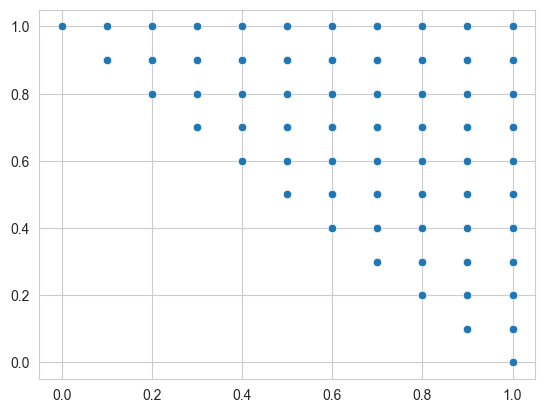

In [2]:
s = np.mgrid[0:1:11j, 0:1:11j]
s = s.reshape(2, -1).T
slice = 0.99
s = s[s[:, 1] > -s[:, 0] + slice]
s = np.concatenate([s, s, s], axis=0)
sns.scatterplot(x=s[:, 0], y=s[:, 1])

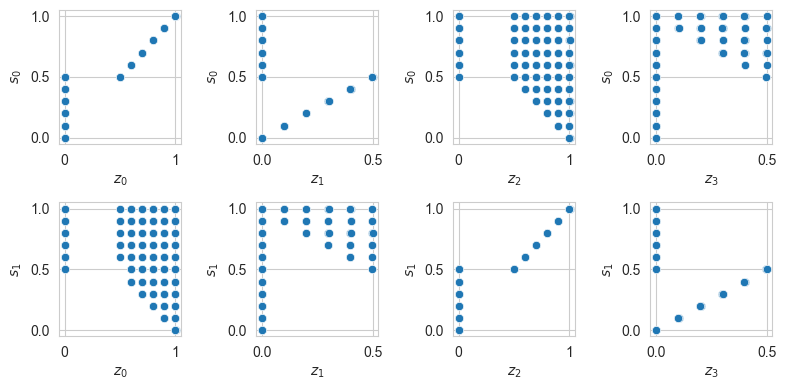

In [3]:
std = 0.001
z0 = s[:, 0] + std * np.random.randn(s.shape[0])
z0[z0 < 0.5] = 0
z1 = s[:, 0] + std * np.random.randn(s.shape[0])
z1[z1 >= 0.5] = 0
z2 = s[:, 1] + std * np.random.randn(s.shape[0])
z2[z2 < 0.5] = 0
z3 = s[:, 1] + std * np.random.randn(s.shape[0])
z3[z3 >= 0.5] = 0
z = np.stack([z0, z1, z2, z3], axis=1)
ns = s.shape[1]
nz = z.shape[1]
fig, axes = plt.subplots(ns, nz, figsize=(2 * nz, 2 * ns))
for i in range(ns):
    for j in range(nz):
        ax = axes[i][j]
        sns.scatterplot(
            ax=ax,
            x=z[:, j],
            y=s[:, i],
            rasterized=True
        )
        ax.set_xlabel(rf'$z_{{{j}}}$')
        ax.set_ylabel(rf'$s_{{{i}}}$')
fig.tight_layout()

In [6]:
def entropy(x):
    _, counts = np.unique(x, return_counts=True, axis=0)
    p_x = counts / x.shape[0]
    return -np.sum(p_x * np.log2(p_x))

def conditional_entropy(x, y):
    """H(X|Y) = H(X, Y) - H(Y)"""
    H_xy = entropy(np.concatenate([x, y], axis=1))
    H_y = entropy(y)
    return H_xy - H_y

def compute_ncmi(s, z, n_neighbors=10):
    """
    Normalized conditional mutual information between sources s and latents z.
    The [i, j] element is the conditional mutual information between the i-th source and the j-th latent 
    given the rest of the sources, normalized by the conditional entropy of the i-th source given the rest
    of the sources.
    I(z_j; s_i | s_{-i}) = I(z_j; s_i, s_{-i}) - I(z_j; s_{-i}) = I(z_j; s) - I(z_j; s_{-i})
    NCMI[i, j] = I(z_j; s_i | s_{-i}) / H(s_i | s_{-i})
    """
    
    ds = s.shape[1]
    dz = z.shape[1]
    
    I_z_j_and_s_joint = np.empty(shape=(dz,))
    s_joint = LabelEncoder().fit_transform([str(s_sample) for s_sample in s])
    for j in range(dz):
        I_z_j_and_s_joint[j] = mutual_info_classif(z[:, j].reshape(-1, 1), s_joint, n_neighbors=n_neighbors).squeeze()
    
    ncmi = np.empty(shape=(ds, dz))
    for i in range(ds):
        s_rest = s[:, np.arange(ds) != i]
        s_rest_str = LabelEncoder().fit_transform([str(s_sample) for s_sample in s_rest])
        for j in range(dz):
            I_z_j_and_s_rest = mutual_info_classif(z[:, j].reshape(-1, 1), s_rest_str, n_neighbors=n_neighbors).squeeze()
            ncmi[i, j] = I_z_j_and_s_joint[j] - I_z_j_and_s_rest
        H_s_i_given_s_rest = conditional_entropy(s[:, i].reshape(-1, 1), s_rest)
        ncmi[i, :] /= H_s_i_given_s_rest
    return ncmi

def compute_cinfomec(s, z):
    """
    Compute CInfoM, CInfoC, and InfoE between discrete sources s and continuous latents z.
    s: np.ndarray, shape=(n_samples, n_sources)
    z: np.ndarray, shape=(n_samples, n_latents)
    
    Inactive latents are heuristically identified by their range being less than a proportion of the range of the most active latent. Inactive latents are ignored in the computation of CInfoM and CInfoC.
    """
    ncmi = compute_ncmi(s, z)
    ncmi[ncmi < 0] = 0
    
    z_ranges = np.max(z, axis=0) - np.min(z, axis=0)
    max_z_range = np.max(z_ranges)
    z_active = z_ranges > 0.1 * max_z_range
    
    ds = s.shape[1]
    ncmi_active = ncmi[:, z_active]
    dz_active = np.sum(z_active)
    if dz_active == 0:
        return {
            'CInfoM': 0,
            'CInfoC': 0,
            # 'InfoE': 0,
            'NCMI': ncmi,
            'z_active': z_active
        }
    cinfom = (np.mean(np.max(ncmi_active, axis=0) / np.sum(ncmi_active, axis=0)) - 1 / ds) / (
                1 - 1 / ds)
    cinfoc = (np.mean(np.max(ncmi_active, axis=1) / np.sum(ncmi_active, axis=1)) - 1 / dz_active) / (
                1 - 1 / dz_active)
    # infoe = infomec.compute_infoe(s, z, 'discrete', 'continuous')
    return {
        'CInfoM': cinfom,
        'CInfoC': cinfoc,
        # 'InfoE': infoe,
        'NCMI': ncmi,
        'z_active': z_active
    }

In [7]:
compute_cinfomec(s, z)

{'CInfoM': 0.9897231255608017,
 'CInfoC': 0.5392074821879943,
 'NCMI': array([[0.54682745, 0.26257899, 0.        , 0.00316059],
        [0.00549891, 0.        , 0.52482422, 0.29506901]]),
 'z_active': array([ True,  True,  True,  True])}